In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import wfdb
import pandas as pd
import ast
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics

import data_visualisation as dv
import data_augmentation as da
# from PTBXL import PTBXL
import importlib

importlib.reload(dv)
importlib.reload(da)

2024-04-18 15:41:25.451281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 15:41:25.981161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-18 15:41:25.981224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-18 15:41:25.981231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:

path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=100

# load and convert annotation data
DF = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
DF.scp_codes = DF.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
print('Loading data...')
X = load_raw_data(DF, sampling_rate, path)
print('Data loaded.')

# Load scp_statements.csv for diagnostic aggregation
print('Loading scp_statements...')
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print('Scp statements loaded.')

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
DF['diagnostic_superclass'] = DF.scp_codes.apply(aggregate_diagnostic)

superclasses = np.unique([elem for sublist in DF.diagnostic_superclass for elem in sublist])



Z = pd.DataFrame(0, index=DF.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in DF.loc[i].diagnostic_superclass:
        Z.loc[i, k] = 1
        
test_fold = 10
val_fold = 9

X_train = X[np.where(DF.strat_fold <= 8)]
y_train = Z[(DF.strat_fold <= 8)]
y_train_text = DF[(DF.strat_fold <= 8)].diagnostic_superclass

X_val = X[np.where(DF.strat_fold == val_fold)]
y_val = Z[DF.strat_fold == val_fold]

X_test = X[np.where(DF.strat_fold == test_fold)]
y_test = Z[DF.strat_fold == test_fold]

Loading data...
Data loaded.
Loading scp_statements...
Scp statements loaded.


(1000, 12)


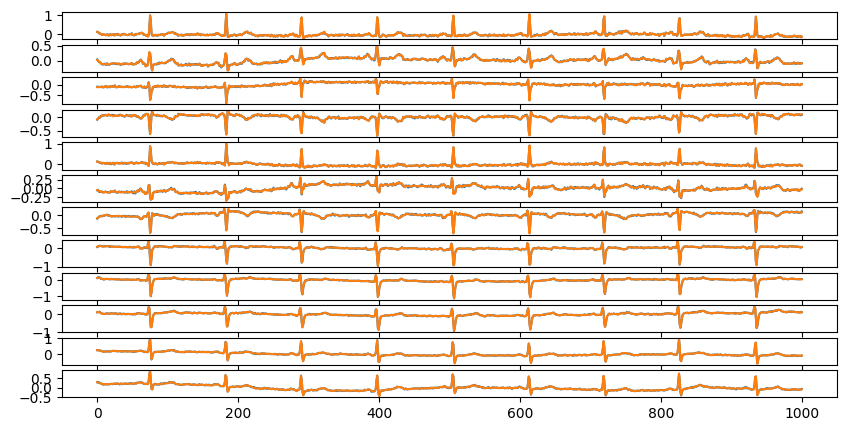

['STTC']
NORM    0
MI      0
STTC    1
CD      0
HYP     0
Name: 2564, dtype: int64


In [4]:
rand = random.randint(0, len(X_train))

sample = X_train[rand]
print(sample.shape)

augmented_sample = da.add_random_noise(sample, 0.1)
aug2 = da.add_random_baseline_drift(sample.transpose(0,1), strength=1)

bar, axes = plt.subplots(sample.shape[1], 1, figsize=(10,5))
for i in range(sample.shape[1]):
    # sns.lineplot(x=np.arange(sample.shape[0]), y=aug2[:, i], ax=axes[i])
    sns.lineplot(x=np.arange(sample.shape[0]), y=augmented_sample[:, i], ax=axes[i])
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
#plt.tight_layout()
plt.show()
print(y_train_text.iloc[rand])
print(y_train.iloc[rand])

In [5]:
from sklearn.preprocessing import StandardScaler



# Normalise data
X_scaler = StandardScaler()
X_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

X_train = X_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# convert x_train to tensors
# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train.values)


In [118]:
NP_DATA_LR = 'data/PTB_XL_lr.npz'

save_args = {
    'X_train': X_train.astype(np.float32),
    'X_val': X_val.astype(np.float32),
    'X_test': X_test.astype(np.float32),
    'y_train': y_train.values.astype(np.float32),
    'y_train_text': y_train_text,
    'y_val': y_val.values.astype(np.float32),
    'y_test': y_test.values.astype(np.float32),
}

np.savez(NP_DATA_LR, **save_args)

In [2]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/PTB_XL.npz'
NP_DATA_LR = 'data/PTB_XL_lr.npz'

with np.load(NP_DATA_LR, allow_pickle=True) as data:
    for k in data.keys():
        if k == 'y_train_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

Train data shape:  (17418, 1000, 12) Train labels shape:  (17418, 5) Train labels text shape:  (17418,)
Val data shape:  (2183, 1000, 12) Val labels shape:  (2183, 5)
Test data shape:  (2198, 1000, 12) Test labels shape:  (2198, 5)
Random sample:  16213
['NORM', 'MI', 'STTC', 'CD', 'HYP']
Labels:  [1. 0. 0. 0. 0.]
Labels:  ['NORM']


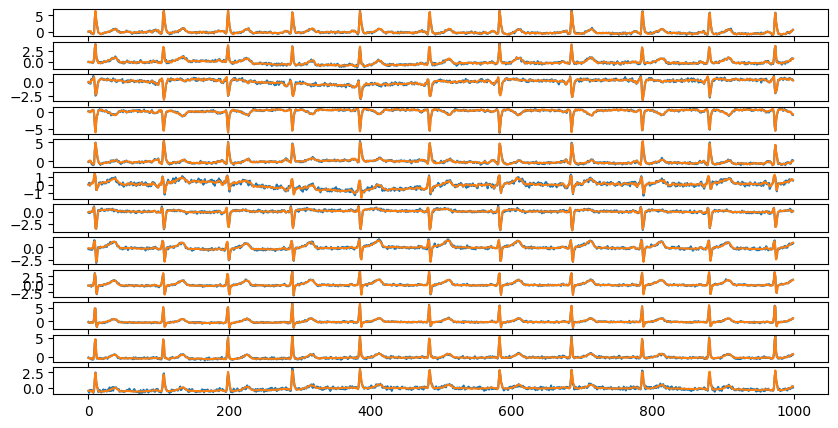

In [3]:
print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)
print('Val data shape: ', X_val.shape, 'Val labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape, 'Test labels shape: ', y_test.shape)

rand_sample_i = random.randint(0, X_train.shape[0])
print('Random sample: ', rand_sample_i)
rand_sample = X_train[rand_sample_i]

augmented_sample = da.add_random_noise(rand_sample, 0.2)

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=augmented_sample[:, i], ax=axes[i])
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

print(['NORM', 'MI', 'STTC', 'CD', 'HYP'])
print('Labels: ', y_train[rand_sample_i])
print('Labels: ', y_train_text[rand_sample_i])



In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.regularizers as regularizers
import keras.metrics as metrics
# import keras

num_classes = 5 #len(superclasses)

# Define the input shape
input_shape = (5000, 12)  # 5000 time points, 12 leads

# model = keras.Sequential([
#     keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape),
#     keras.layers.MaxPool1D(2),
#     keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
#     keras.layers.MaxPool1D(2),
#     # keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
#     # keras.layers.MaxPool1D(3),
#     # keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
#     # keras.layers.MaxPool1D(2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(num_classes, activation='sigmoid')
# ])
#use batch normalization
# model = keras.Sequential([
#     keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool1D(4),
#     keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.MaxPool1D(3),
#     keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool1D(2),
#     keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool1D(2),
#     keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
#     keras.layers.Conv1D(filters=4, kernel_size=1, activation='relu'),
#     keras.layers.Flatten(),
#     keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dense(num_classes, activation='sigmoid')
# ])

# model = keras.Sequential([
#     keras.layers.Conv1D(filters=24, kernel_size=5, padding='same', activation='relu', input_shape=input_shape, 
#                         kernel_regularizer=regularizers.l2(0.001)),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPooling1D(4),
#     keras.layers.Dropout(0.3),
#     keras.layers.Conv1D(filters=48, kernel_size=5, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPooling1D(3),
#     keras.layers.Conv1D(filters=12, kernel_size=5, padding='same', activation='relu'),
#     keras.layers.Flatten(),
#     keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', metrics.binary_accuracy])
# model.summary()




In [4]:
with tf.device('CPU:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2024-04-18 11:21:41.091499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 11:21:41.182232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 11:21:41.182432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 11:21:41.183714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
train_dataset = train_dataset.shuffle(len(X_train)).batch(64)
val_dataset = val_dataset.batch(64)

test_dataset = test_dataset.batch(64)

In [99]:
MODEL_CHECKPOINT = 'models/model1.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model.fit(train_dataset, epochs=100, batch_size=32, validation_data=val_dataset)

Epoch 1/100
545/545 [==============================] - 8s 11ms/step - loss: 0.5605 - accuracy: 0.5334 - auc: 0.7776 - precision: 0.6231 - recall: 0.3887 - binary_accuracy: 0.7844 - val_loss: 0.8308 - val_accuracy: 0.5025 - val_auc: 0.7796 - val_precision: 0.6051 - val_recall: 0.3916 - val_binary_accuracy: 0.7795
Epoch 2/100
545/545 [==============================] - 6s 11ms/step - loss: 0.4664 - accuracy: 0.6320 - auc: 0.8561 - precision: 0.7263 - recall: 0.5232 - binary_accuracy: 0.8283 - val_loss: 0.5153 - val_accuracy: 0.6148 - val_auc: 0.8514 - val_precision: 0.7008 - val_recall: 0.5363 - val_binary_accuracy: 0.8232
Epoch 3/100
545/545 [==============================] - 6s 11ms/step - loss: 0.4428 - accuracy: 0.6636 - auc: 0.8782 - precision: 0.7524 - recall: 0.5781 - binary_accuracy: 0.8441 - val_loss: 0.5798 - val_accuracy: 0.6148 - val_auc: 0.8504 - val_precision: 0.7070 - val_recall: 0.5032 - val_binary_accuracy: 0.8200
Epoch 4/100
545/545 [==============================] - 7s 

KeyboardInterrupt: 

In [9]:
num_classes = 5 #len(superclasses)

model2 = keras.Sequential([
    keras.layers.LSTM(512, input_shape=(5000, 12), return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    # keras.layers.LSTM(64, return_sequences=False),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.binary_accuracy, 'accuracy', 'AUC', 'Precision', 'Recall'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512)               1075200   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                8208      
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,085,541
Trainable params: 1,084,517
Non-trainable params: 1,024
________________________________________

In [112]:
MODEL2_CHECKPOINT = 'models/models.keras'

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20),
    keras.callbacks.ModelCheckpoint(filepath=MODEL2_CHECKPOINT, monitor='val_binary_accuracy', save_best_only=True)
]

history = model2.fit(train_dataset, epochs=100, batch_size=64, validation_data=val_dataset)

Epoch 1/100
273/273 [==============================] - 80s 287ms/step - loss: 0.5966 - binary_accuracy: 0.7390 - accuracy: 0.3729 - auc: 0.6152 - precision: 0.4448 - recall: 0.0983 - val_loss: 0.6553 - val_binary_accuracy: 0.7247 - val_accuracy: 0.4521 - val_auc: 0.6363 - val_precision: 0.4439 - val_recall: 0.3112
Epoch 2/100
273/273 [==============================] - 78s 288ms/step - loss: 0.5432 - binary_accuracy: 0.7479 - accuracy: 0.4483 - auc: 0.6558 - precision: 0.5351 - recall: 0.0793 - val_loss: 0.5539 - val_binary_accuracy: 0.7448 - val_accuracy: 0.4352 - val_auc: 0.6284 - val_precision: 0.5000 - val_recall: 0.0068
Epoch 3/100
273/273 [==============================] - 79s 289ms/step - loss: 0.5377 - binary_accuracy: 0.7484 - accuracy: 0.4497 - auc: 0.6629 - precision: 0.5419 - recall: 0.0814 - val_loss: 0.7974 - val_binary_accuracy: 0.7438 - val_accuracy: 0.2410 - val_auc: 0.4512 - val_precision: 0.4194 - val_recall: 0.0093
Epoch 4/100
273/273 [==============================]

KeyboardInterrupt: 

In [13]:
# model for low resolution data

def cnn_model(X, num_classes=5, filters = [32, 64, 128], kernels = [5,3,3]):
    
    X = keras.layers.Conv1D(filters=filters[0], kernel_size=kernels[0], input_shape=X.shape[1:])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[1], kernel_size=kernels[1])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[2], kernel_size=kernels[2])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    features_output = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dropout(0.5)(features_output)
    
    X = keras.layers.Dense(128, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    
    return X, features_output

num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn_model(X_input, num_classes=num_classes)

model = keras.Model(inputs=X_input, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 32)           1952      
                                                                 
 batch_normalization_5 (Batc  (None, 996, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 996, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 498, 32)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 496, 64)           6208

In [14]:
feat_extractor_model = keras.Model(inputs=X_input, outputs=feature_output)
feat_extractor_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
feat_extractor_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 32)           1952      
                                                                 
 batch_normalization_5 (Batc  (None, 996, 32)          128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 996, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 498, 32)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 496, 64)           6208

In [15]:
# fit

cp_callback = keras.callbacks.ModelCheckpoint(filepath='models/cnn_model.keras', save_weights_only=True, verbose=1, save_best_only=True, monitor='val_binary_accuracy')

history = model.fit(train_dataset, epochs=100, batch_size=64, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/100


271/273 [============================>.] - ETA: 0s - loss: 0.4144 - accuracy: 0.5829 - precision: 0.7056 - recall: 0.4542 - binary_accuracy: 0.8127
Epoch 1: val_binary_accuracy improved from -inf to 0.84553, saving model to models/cnn_model.keras
273/273 [==============================] - 4s 8ms/step - loss: 0.4144 - accuracy: 0.5830 - precision: 0.7055 - recall: 0.4545 - binary_accuracy: 0.8127 - val_loss: 0.3554 - val_accuracy: 0.6509 - val_precision: 0.7309 - val_recall: 0.6249 - val_binary_accuracy: 0.8455
Epoch 2/100
269/273 [============================>.] - ETA: 0s - loss: 0.3543 - accuracy: 0.6508 - precision: 0.7518 - recall: 0.5979 - binary_accuracy: 0.8473
Epoch 2: val_binary_accuracy improved from 0.84553 to 0.85268, saving model to models/cnn_model.keras
273/273 [==============================] - 2s 8ms/step - loss: 0.3543 - accuracy: 0.6507 - precision: 0.7521 - recall: 0.5980 - binary_accuracy: 0.8474 - val_loss: 0.3401 - val_accuracy: 0.6519 - val_precision: 0.7345 - va

In [16]:
os.listdir('models')

['cnn_model.keras']

In [18]:
feat_extractor_model.load_weights('models/cnn_model.keras', by_name=True)

In [193]:
from sklearn.metrics import classification_report, f1_score, accuracy_score


y_pred = model.predict(X_train, verbose=1)
y_true = y_train
threshold = 0.5
y_pred_binary = y_pred > threshold


classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP'] 
print(classification_report(y_true, y_pred_binary, target_names=classes))

545/545 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

        NORM       0.90      0.95      0.92      7596
          MI       0.88      0.85      0.86      4379
        STTC       0.88      0.74      0.80      4186
          CD       0.89      0.80      0.84      3907
         HYP       0.87      0.60      0.71      2119

   micro avg       0.89      0.83      0.86     22187
   macro avg       0.88      0.79      0.83     22187
weighted avg       0.89      0.83      0.85     22187
 samples avg       0.86      0.84      0.84     22187



/home/raaif/anaconda3/envs/FYP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/raaif/anaconda3/envs/FYP/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [160]:
def lr_lstm_model(X, num_classes=5):
    
    X = keras.layers.LSTM(256, return_sequences=False)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dropout(0.5)(X)
    
    X = keras.layers.Dense(64, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    return X

model3 = keras.Model(inputs=X_input, outputs=lr_lstm_model(X_input, num_classes=num_classes))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model3.summary()

# fit
history = model3.fit(train_dataset, epochs=100, batch_size=64, validation_data=val_dataset)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1000, 12)]        0         
                                                                 
 lstm_12 (LSTM)              (None, 256)               275456    
                                                                 
 batch_normalization_153 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_42 (Dropout)        (None, 256)               0         
                                                                 
 dense_126 (Dense)           (None, 64)                16448     
                                                                 
 dense_127 (Dense)           (None, 5)                 325       
                                                          

In [11]:
import tensorflow as tf
import tensorflow.keras as keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import torch

torch.cuda.is_available()

True